In [55]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Exoplanet Detection ML Pipeline - NASA Space App Challenge")
print("=" * 60)
df = pd.read_csv(r'E:\Nasa Space App 2025\Hunting_For_Exoplanets_With_AI_Nasa2025\DataSet\KOI\your_file_updated.csv', comment='#')

print(f"Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"\nTarget variable distribution:")
print(df['koi_disposition'].value_counts())
print(f"\nFirst 5 rows:")
print(df.head())

Exoplanet Detection ML Pipeline - NASA Space App Challenge
Dataset loaded successfully!
Dataset shape: (9464, 49)

Target variable distribution:
koi_disposition
FALSE POSITIVE    4758
CONFIRMED         2746
CANDIDATE         1960
Name: count, dtype: int64

First 5 rows:
      kepid kepoi_name   kepler_name koi_disposition koi_pdisposition  \
0  10797460  K00752.01  Kepler-227 b       CONFIRMED        CANDIDATE   
1  10797460  K00752.02  Kepler-227 c       CONFIRMED        CANDIDATE   
2  10811496  K00753.01           NaN       CANDIDATE        CANDIDATE   
3  10848459  K00754.01           NaN  FALSE POSITIVE   FALSE POSITIVE   
4  10854555  K00755.01  Kepler-664 b       CONFIRMED        CANDIDATE   

   koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  ...  \
0      1.000              0              0              0              0  ...   
1      0.969              0              0              0              0  ...   
2      0.000              0              0     

In [56]:
df.isnull().sum()

kepid                   0
kepoi_name              0
kepler_name          6717
koi_disposition         0
koi_pdisposition        0
koi_score            1510
koi_fpflag_nt           0
koi_fpflag_ss           0
koi_fpflag_co           0
koi_fpflag_ec           0
koi_period              0
koi_period_err1       450
koi_period_err2       450
koi_time0bk             0
koi_time0bk_err1      450
koi_time0bk_err2      450
koi_impact            361
koi_impact_err1       450
koi_impact_err2       450
koi_duration            0
koi_duration_err1     450
koi_duration_err2     450
koi_depth             361
koi_depth_err1        450
koi_depth_err2        450
koi_prad              361
koi_prad_err1         361
koi_prad_err2         361
koi_teq               361
koi_teq_err1         9464
koi_teq_err2         9464
koi_insol             319
koi_insol_err1        319
koi_insol_err2        319
koi_model_snr         361
koi_tce_plnt_num      346
koi_tce_delivname     346
koi_steff             361
koi_steff_er

In [57]:
print("\nBlock 2: Data Quality Assessment")

# Check for missing values
print("Missing values per column:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Percentage': missing_percent
}).sort_values('Missing Count', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])

# Basic statistics
print(f"\nDataset Info:")
print(df.info())


Block 2: Data Quality Assessment
Missing values per column:
                   Missing Count  Percentage
koi_teq_err1                9464  100.000000
koi_teq_err2                9464  100.000000
kepler_name                 6717   70.974218
koi_score                   1510   15.955199
koi_steff_err2               481    5.082418
koi_srad_err1                466    4.923922
koi_steff_err1               466    4.923922
koi_slogg_err2               466    4.923922
koi_slogg_err1               466    4.923922
koi_srad_err2                466    4.923922
koi_time0bk_err1             450    4.754861
koi_period_err1              450    4.754861
koi_period_err2              450    4.754861
koi_time0bk_err2             450    4.754861
koi_impact_err1              450    4.754861
koi_depth_err1               450    4.754861
koi_depth_err2               450    4.754861
koi_duration_err1            450    4.754861
koi_duration_err2            450    4.754861
koi_impact_err2              450    4.7

In [58]:

print("\nBlock 3: Data Preprocessing")

# Create a copy for preprocessing
df_processed = df.copy()

# Define feature columns (excluding ID and target)
feature_columns = [col for col in df_processed.columns if col not in ['kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 'koi_pdisposition']]

print(f"Feature columns identified: {len(feature_columns)} features")
print(f"Features: {feature_columns}")

# Handle missing values
print("\n🔧 Handling missing values...")

# Separate numeric and categorical features
numeric_features = df_processed[feature_columns].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df_processed[feature_columns].select_dtypes(include=['object']).columns.tolist()

print(f"Numeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")

# Impute missing values for numeric features
if len(numeric_features) > 0:
    print("Imputing numeric features...")
    for col in numeric_features:
        if df_processed[col].isnull().sum() > 0:
            median_val = df_processed[col].median()
            df_processed[col] = df_processed[col].fillna(median_val)
            print(f"  - {col}: filled {df_processed[col].isnull().sum()} missing values")

# Impute missing values for categorical features
if len(categorical_features) > 0:
    print("Imputing categorical features...")
    for col in categorical_features:
        if df_processed[col].isnull().sum() > 0:
            mode_val = df_processed[col].mode().iloc[0] if not df_processed[col].mode().empty else 'Unknown'
            df_processed[col] = df_processed[col].fillna(mode_val)
            print(f"  - {col}: filled {df_processed[col].isnull().sum()} missing values")

print("Missing values handled")

# Prepare target variable
target_encoder = LabelEncoder()
df_processed['target_encoded'] = target_encoder.fit_transform(df_processed['koi_disposition'])

print(f"\nTarget encoding:")
for i, label in enumerate(target_encoder.classes_):
    print(f"{i}: {label}")


Block 3: Data Preprocessing
Feature columns identified: 44 features
Features: ['koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration', 'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad', 'koi_prad_err1', 'koi_prad_err2', 'koi_teq', 'koi_teq_err1', 'koi_teq_err2', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2', 'koi_model_snr', 'koi_tce_plnt_num', 'koi_tce_delivname', 'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad', 'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag']

🔧 Handling missing values...
Numeric features: 43
Categorical features: 1
Imputing numeric features...
  - koi_score: filled 0 missing values
  - koi_period_err1: filled 0 missing values
  - koi_period_err

In [59]:
df_processed.isnull().sum() 

kepid                   0
kepoi_name              0
kepler_name          6717
koi_disposition         0
koi_pdisposition        0
koi_score               0
koi_fpflag_nt           0
koi_fpflag_ss           0
koi_fpflag_co           0
koi_fpflag_ec           0
koi_period              0
koi_period_err1         0
koi_period_err2         0
koi_time0bk             0
koi_time0bk_err1        0
koi_time0bk_err2        0
koi_impact              0
koi_impact_err1         0
koi_impact_err2         0
koi_duration            0
koi_duration_err1       0
koi_duration_err2       0
koi_depth               0
koi_depth_err1          0
koi_depth_err2          0
koi_prad                0
koi_prad_err1           0
koi_prad_err2           0
koi_teq                 0
koi_teq_err1         9464
koi_teq_err2         9464
koi_insol               0
koi_insol_err1          0
koi_insol_err2          0
koi_model_snr           0
koi_tce_plnt_num        0
koi_tce_delivname       0
koi_steff               0
koi_steff_er


Block 4: Exploratory Data Analysis


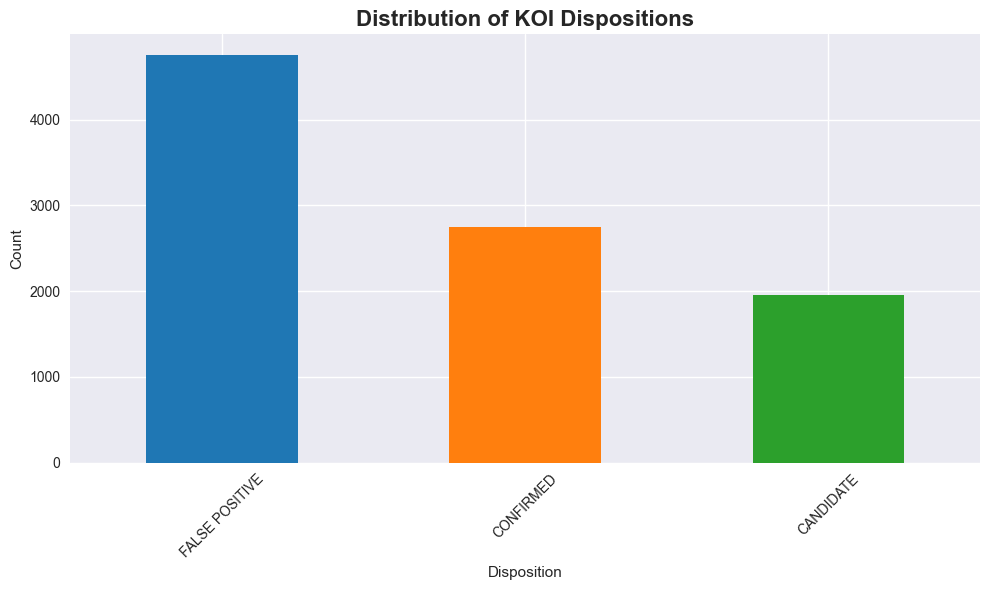

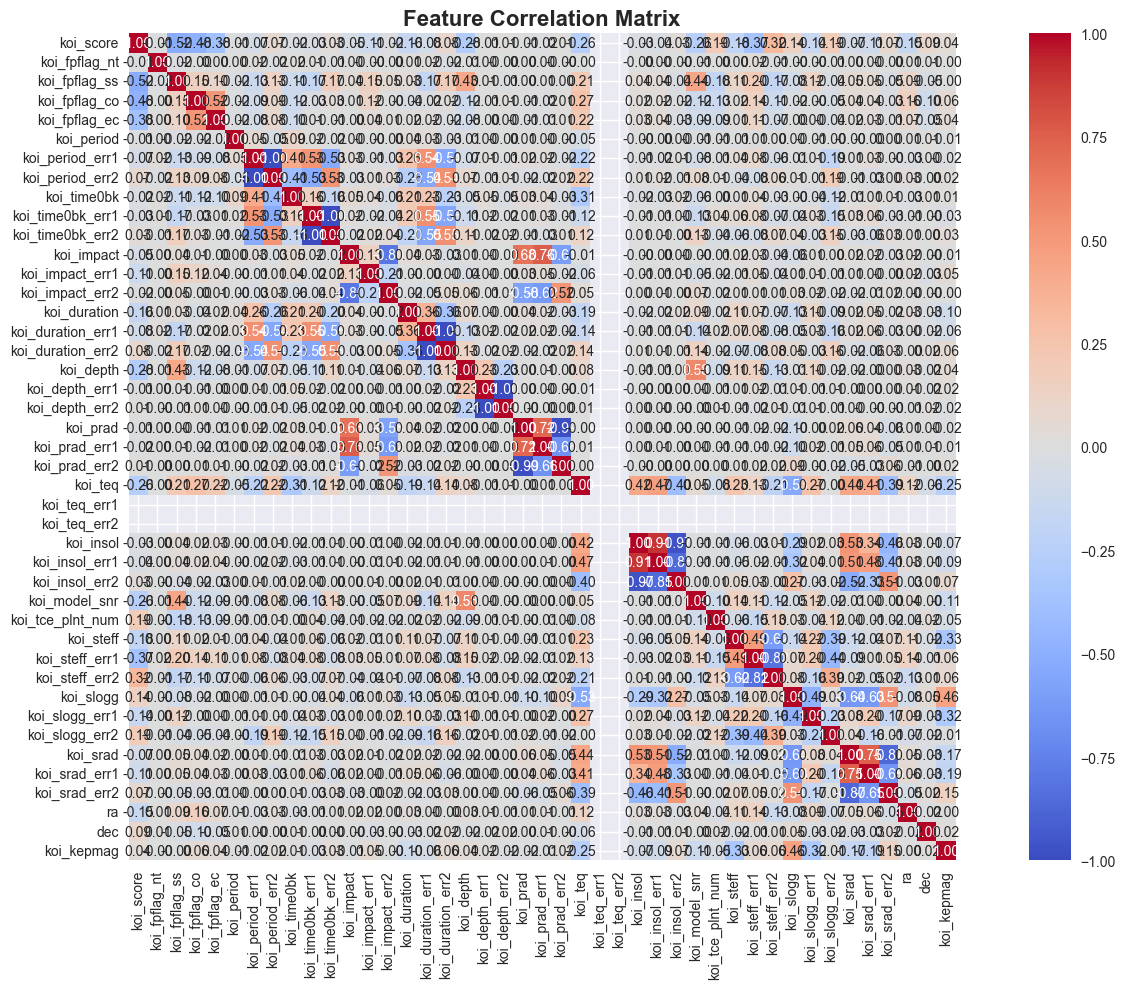

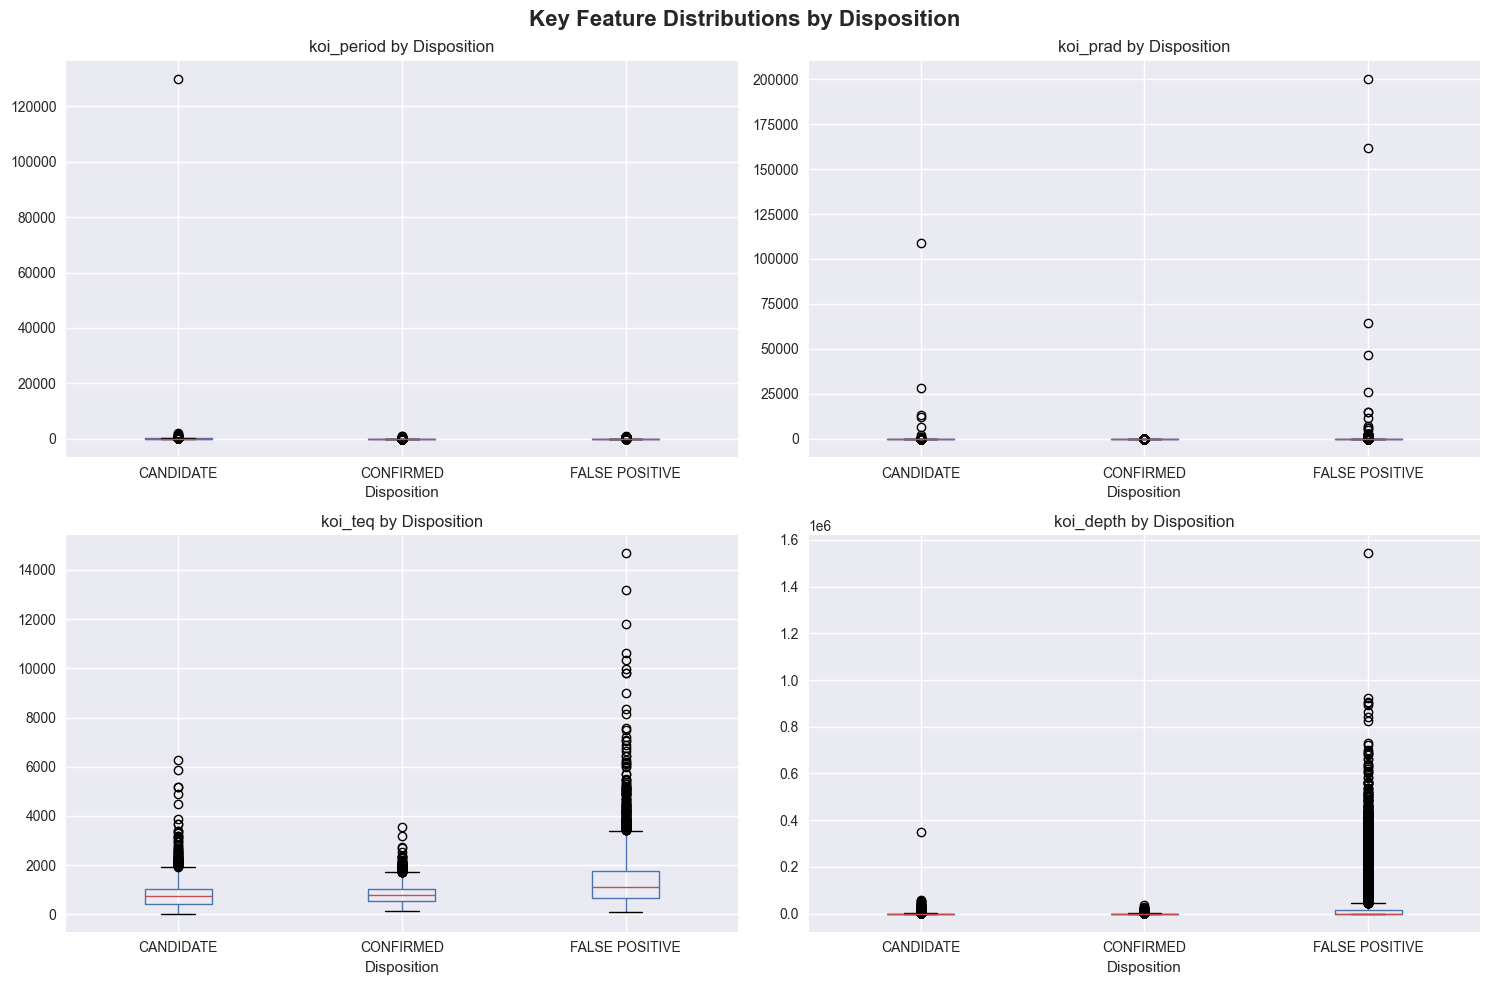

In [60]:

print("\nBlock 4: Exploratory Data Analysis")

# Set up plotting style
plt.style.use('seaborn-v0_8')
fig_size = (15, 10)

# Target distribution
plt.figure(figsize=(10, 6))
df['koi_disposition'].value_counts().plot(kind='bar', color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Distribution of KOI Dispositions', fontsize=16, fontweight='bold')
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation matrix for numeric features
if len(numeric_features) > 5: 
    plt.figure(figsize=fig_size)
    correlation_matrix = df_processed[numeric_features].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                fmt='.2f', square=True)
    plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Distribution of key features
key_features = ['koi_period', 'koi_prad', 'koi_teq', 'koi_depth', 'koi_model_snr']
available_key_features = [f for f in key_features if f in numeric_features]

if len(available_key_features) >= 4:
    fig, axes = plt.subplots(2, 2, figsize=fig_size)
    axes = axes.ravel()
    
    for i, feature in enumerate(available_key_features[:4]):
        df_processed.boxplot(column=feature, by='koi_disposition', ax=axes[i])
        axes[i].set_title(f'{feature} by Disposition')
        axes[i].set_xlabel('Disposition')
    
    plt.suptitle('Key Feature Distributions by Disposition', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [61]:
print("Block 5: Feature Engineering")

df_engineered = df_processed.copy()

# Feature engineering based on physical relationships
if 'koi_period' in numeric_features and 'koi_prad' in numeric_features:
    # Planet density proxy (assuming circular orbit)
    df_engineered['period_to_radius_ratio'] = df_engineered['koi_period'] / (df_engineered['koi_prad'] ** 3)

if 'koi_depth' in numeric_features and 'koi_prad' in numeric_features:
    # Transit depth should be related to planet radius squared
    df_engineered['depth_to_radius_sq'] = df_engineered['koi_depth'] / (df_engineered['koi_prad'] ** 2)

if 'koi_duration' in numeric_features and 'koi_period' in numeric_features:
    # Transit duration to period ratio
    df_engineered['duration_period_ratio'] = df_engineered['koi_duration'] / df_engineered['koi_period']

if 'koi_teq' in numeric_features and 'koi_steff' in numeric_features:
    # Temperature ratio (planet to star)
    df_engineered['temp_ratio'] = df_engineered['koi_teq'] / df_engineered['koi_steff']

# Update feature list
engineered_features = [col for col in df_engineered.columns 
                      if col not in ['kepid', 'kepoi_name', 'kepler_name', 'koi_disposition', 
                                   'koi_pdisposition', 'target_encoded'] and 
                      df_engineered[col].dtype in ['float64', 'int64']]

print(f"Feature engineering completed")
print(f"Total features after engineering: {len(engineered_features)}")
print(f"New engineered features: {[col for col in engineered_features if col not in numeric_features]}")


Block 5: Feature Engineering
Feature engineering completed
Total features after engineering: 47
New engineered features: ['period_to_radius_ratio', 'depth_to_radius_sq', 'duration_period_ratio', 'temp_ratio']


In [62]:
print("\nBlock 6: Data Splitting and Scaling")

# Prepare features and target
X = df_engineered[engineered_features].copy()
y = df_engineered['target_encoded'].copy()

# Check for any remaining missing or infinite values
print(f"  Checking data quality:")
print(f"  NaN values in X: {X.isnull().sum().sum()}")
print(f"  Infinite values in X: {np.isinf(X.values).sum()}")

# Remove any remaining infinite or NaN values
X = X.replace([np.inf, -np.inf], np.nan)

# Fill remaining NaN values with column medians
for col in X.columns:
    if X[col].isnull().sum() > 0:
        median_val = X[col].median()
        if pd.isna(median_val):  # If median is also NaN, use 0
            median_val = 0
        X[col] = X[col].fillna(median_val)
        print(f"  Filled {col} with median value: {median_val}")

# Final check
print(f"\nAfter cleaning:")
print(f"  NaN values in X: {X.isnull().sum().sum()}")
print(f"  Infinite values in X: {np.isinf(X.values).sum()}")

print(f"Final feature matrix shape: {X.shape}")
print(f"Target distribution: {np.bincount(y)}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"   Data split completed:")
print(f"   Training set: {X_train.shape[0]} samples")
print(f"   Test set: {X_test.shape[0]} samples")



Block 6: Data Splitting and Scaling
  Checking data quality:
  NaN values in X: 18928
  Infinite values in X: 0
  Filled koi_teq_err1 with median value: 0
  Filled koi_teq_err2 with median value: 0

After cleaning:
  NaN values in X: 0
  Infinite values in X: 0
Final feature matrix shape: (9464, 47)
Target distribution: [1960 2746 4758]
   Data split completed:
   Training set: 7571 samples
   Test set: 1893 samples


In [63]:
X_train.isnull().sum()

koi_score                 0
koi_fpflag_nt             0
koi_fpflag_ss             0
koi_fpflag_co             0
koi_fpflag_ec             0
koi_period                0
koi_period_err1           0
koi_period_err2           0
koi_time0bk               0
koi_time0bk_err1          0
koi_time0bk_err2          0
koi_impact                0
koi_impact_err1           0
koi_impact_err2           0
koi_duration              0
koi_duration_err1         0
koi_duration_err2         0
koi_depth                 0
koi_depth_err1            0
koi_depth_err2            0
koi_prad                  0
koi_prad_err1             0
koi_prad_err2             0
koi_teq                   0
koi_teq_err1              0
koi_teq_err2              0
koi_insol                 0
koi_insol_err1            0
koi_insol_err2            0
koi_model_snr             0
koi_tce_plnt_num          0
koi_steff                 0
koi_steff_err1            0
koi_steff_err2            0
koi_slogg                 0
koi_slogg_err1      

In [64]:
print("\nBlock 7: Model Training and Evaluation")

# Define models to compare
models = {
    'xgboost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', objective="multi:softprob", random_state=42, n_jobs=-1),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True)
}

# Train and evaluate models
model_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train model
    if name == 'SVM':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    # Calculate metrics
    accuracy = np.mean(y_pred == y_test)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    # For multiclass, we'll use macro average for AUC
    if len(np.unique(y)) > 2:
        auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
    else:
        auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])
    
    model_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'auc': auc_score,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f" {name} Results:")
    print(f"   Test Accuracy: {accuracy:.4f}")
    print(f"   CV Accuracy: {cv_mean:.4f} (+/- {cv_std*2:.4f})")
    print(f"   AUC Score: {auc_score:.4f}")


Block 7: Model Training and Evaluation

Training xgboost...
 xgboost Results:
   Test Accuracy: 0.9271
   CV Accuracy: 0.9295 (+/- 0.0061)
   AUC Score: 0.9842

Training Random Forest...
 Random Forest Results:
   Test Accuracy: 0.9218
   CV Accuracy: 0.9171 (+/- 0.0095)
   AUC Score: 0.9803

Training Gradient Boosting...
 Gradient Boosting Results:
   Test Accuracy: 0.9234
   CV Accuracy: 0.9266 (+/- 0.0095)
   AUC Score: 0.9834

Training Logistic Regression...
 Logistic Regression Results:
   Test Accuracy: 0.6756
   CV Accuracy: 0.6690 (+/- 0.0258)
   AUC Score: 0.8338

Training SVM...
 SVM Results:
   Test Accuracy: 0.8590
   CV Accuracy: 0.8535 (+/- 0.0116)
   AUC Score: 0.9625



Block 8: Model Comparison and Best Model Selection
 Model Comparison:
                 Model  Test Accuracy  CV Mean  CV Std  AUC Score
0              xgboost         0.9271   0.9295  0.0031     0.9842
1        Random Forest         0.9218   0.9171  0.0047     0.9803
2    Gradient Boosting         0.9234   0.9266  0.0048     0.9834
3  Logistic Regression         0.6756   0.6690  0.0129     0.8338
4                  SVM         0.8590   0.8535  0.0058     0.9625

Best Model: xgboost
   CV Accuracy: 0.9295
   Test Accuracy: 0.9271

 Detailed Classification Report for xgboost:
                precision    recall  f1-score   support

     CANDIDATE       0.82      0.83      0.83       392
     CONFIRMED       0.89      0.90      0.89       549
FALSE POSITIVE       0.99      0.98      0.99       952

      accuracy                           0.93      1893
     macro avg       0.90      0.90      0.90      1893
  weighted avg       0.93      0.93      0.93      1893



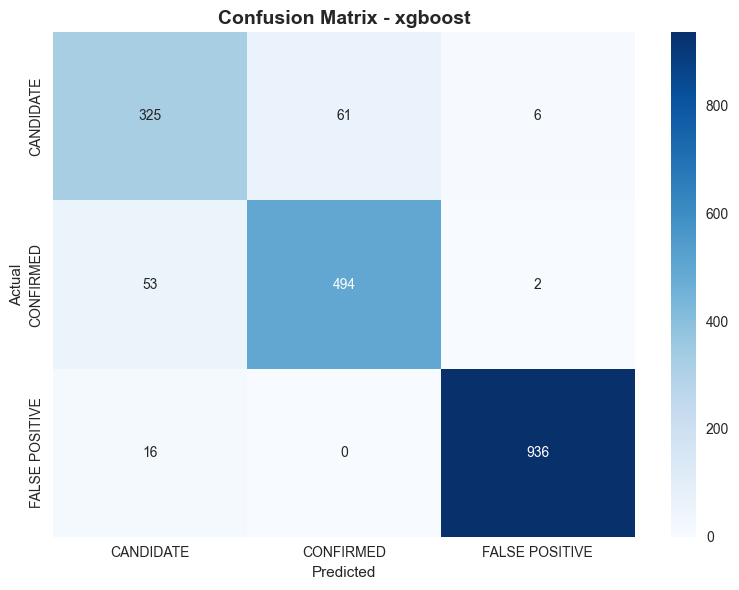

In [65]:
print("\nBlock 8: Model Comparison and Best Model Selection")

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Test Accuracy': [results['accuracy'] for results in model_results.values()],
    'CV Mean': [results['cv_mean'] for results in model_results.values()],
    'CV Std': [results['cv_std'] for results in model_results.values()],
    'AUC Score': [results['auc'] for results in model_results.values()]
})

print(" Model Comparison:")
print(comparison_df.round(4))

# Select best model based on CV accuracy
best_model_name = comparison_df.loc[comparison_df['CV Mean'].idxmax(), 'Model']
best_model_results = model_results[best_model_name]
best_model = best_model_results['model']

print(f"\nBest Model: {best_model_name}")
print(f"   CV Accuracy: {best_model_results['cv_mean']:.4f}")
print(f"   Test Accuracy: {best_model_results['accuracy']:.4f}")

# Detailed classification report for best model
print(f"\n Detailed Classification Report for {best_model_name}:")
print(classification_report(y_test, best_model_results['predictions'], 
                          target_names=target_encoder.classes_))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, best_model_results['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_encoder.classes_, 
            yticklabels=target_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


 Block 9: Feature Importance Analysis
 Top 10 Most Important Features:
                  feature  importance
0               koi_score    0.362806
1           koi_fpflag_nt    0.109265
3           koi_fpflag_co    0.092875
29          koi_model_snr    0.064355
4           koi_fpflag_ec    0.062622
2           koi_fpflag_ss    0.053629
30       koi_tce_plnt_num    0.012665
20               koi_prad    0.012300
45  duration_period_ratio    0.010766
44     depth_to_radius_sq    0.009355


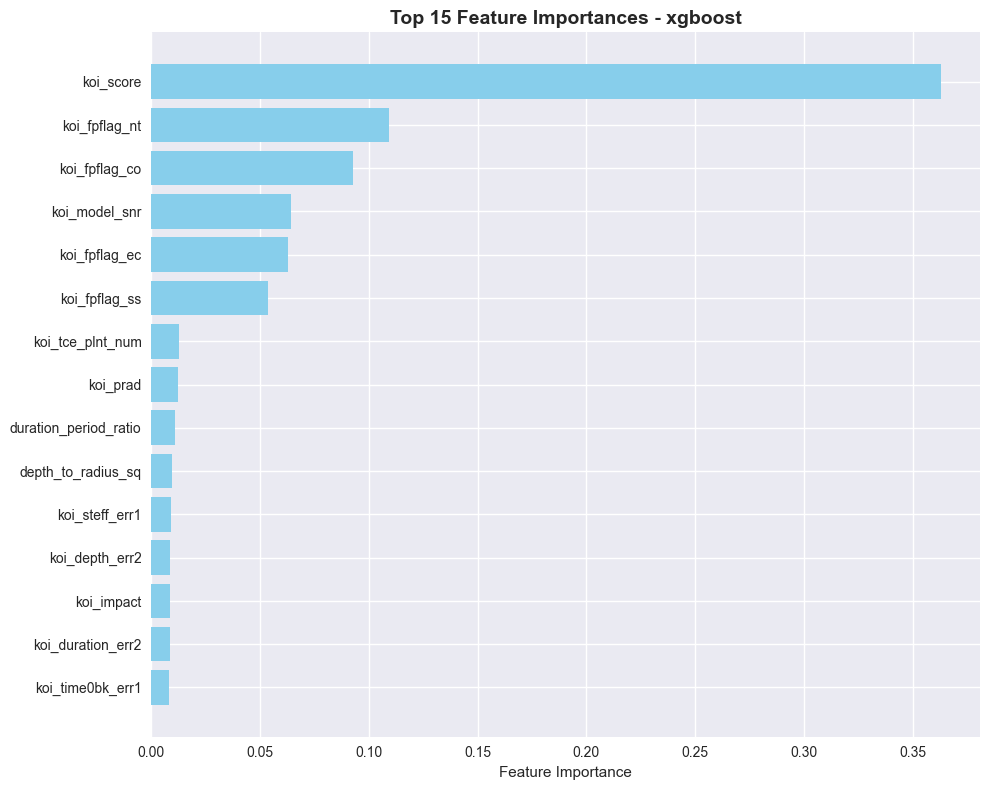

In [66]:
print("\n Block 9: Feature Importance Analysis")

# Feature importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': engineered_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(" Top 10 Most Important Features:")
    print(feature_importance.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'], color='skyblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importances - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [67]:
#%% [Block 10: Model Optimization]
print("\n⚡ Block 10: Model Optimization")

# Hyperparameter tuning for the best model
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    }
elif best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
elif best_model_name == 'xgboost':
    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }
else:  # SVM
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto', 0.001, 0.01]
    }

print(f"🔍 Performing Grid Search for {best_model_name}...")

# Create new model instance for tuning
if best_model_name == 'Random Forest':
    tuning_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    X_tune = X_train
elif best_model_name == 'Gradient Boosting':
    tuning_model = GradientBoostingClassifier(random_state=42)
    X_tune = X_train
elif best_model_name == 'Logistic Regression':
    tuning_model = LogisticRegression(random_state=42, max_iter=1000)
    X_tune = X_train_scaled
elif best_model_name == 'xgboost':
    tuning_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', objective="multi:softprob", random_state=42, n_jobs=-1)
    X_tune = X_train
else:  # SVM
    tuning_model = SVC(random_state=42, probability=True)
    X_tune = X_train_scaled

# Grid search with cross-validation
grid_search = GridSearchCV(tuning_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_tune, y_train)

print(f" Grid Search completed!")
print(f" Best parameters: {grid_search.best_params_}")
print(f" Best CV score: {grid_search.best_score_:.4f}")

# Evaluate optimized model
optimized_model = grid_search.best_estimator_
if best_model_name in ['Logistic Regression', 'SVM']:
    y_pred_optimized = optimized_model.predict(X_test_scaled)
    y_pred_proba_optimized = optimized_model.predict_proba(X_test_scaled)
else:
    y_pred_optimized = optimized_model.predict(X_test)
    y_pred_proba_optimized = optimized_model.predict_proba(X_test)

optimized_accuracy = np.mean(y_pred_optimized == y_test)
if len(np.unique(y)) > 2:
    optimized_auc = roc_auc_score(y_test, y_pred_proba_optimized, multi_class='ovr', average='macro')
else:
    optimized_auc = roc_auc_score(y_test, y_pred_proba_optimized[:, 1])

print(f"\n Optimized Model Performance:")
print(f"    Test Accuracy: {optimized_accuracy:.4f}")
print(f"    AUC Score: {optimized_auc:.4f}")
print(f"    Improvement: {optimized_accuracy - best_model_results['accuracy']:.4f}")



⚡ Block 10: Model Optimization
🔍 Performing Grid Search for xgboost...
Fitting 3 folds for each of 243 candidates, totalling 729 fits
 Grid Search completed!
 Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}
 Best CV score: 0.9321

 Optimized Model Performance:
    Test Accuracy: 0.9271
    AUC Score: 0.9854
    Improvement: 0.0000


In [68]:
print("\n Block 11: Save Model and Results")

import joblib
import json

# Save the optimized model
joblib.dump(optimized_model, 'best_exoplanet_model.joblib')
joblib.dump(scaler, 'feature_scaler.joblib')
joblib.dump(target_encoder, 'target_encoder.joblib')

# Save feature names
with open('feature_names.json', 'w') as f:
    json.dump(engineered_features, f)

# Save model metadata
metadata = {
    'best_model': best_model_name,
    'best_params': grid_search.best_params_,
    'test_accuracy': float(optimized_accuracy),
    'auc_score': float(optimized_auc),
    'cv_score': float(grid_search.best_score_),
    'feature_count': len(engineered_features),
    'target_classes': list(target_encoder.classes_)
}

with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(" Model and artifacts saved successfully!")
print(f" Files saved:")
print(f"    best_exoplanet_model.joblib")
print(f"    feature_scaler.joblib")
print(f"    target_encoder.joblib")
print(f"    feature_names.json")
print(f"    model_metadata.json")


 Block 11: Save Model and Results
 Model and artifacts saved successfully!
 Files saved:
    best_exoplanet_model.joblib
    feature_scaler.joblib
    target_encoder.joblib
    feature_names.json
    model_metadata.json


In [ ]:
# Predict specific rows from your original CSV file

import pandas as pd
import numpy as np
import joblib
import json

def predict_from_csv(csv_file_path, row_numbers):
    """
    Predict exoplanet classification for specific rows from CSV
    
    Parameters:
    csv_file_path: path to your original CSV file
    row_numbers: list of row numbers to predict (0-indexed) or single number
    
    Returns:
    DataFrame with predictions
    """
    print(f" CSV Row Prediction")
    print("=" * 50)
    
    try:
        # Load the original CSV
        print(f" Loading CSV: {csv_file_path}")
        df = pd.read_csv(csv_file_path, comment='#')
        print(f" CSV loaded: {df.shape[0]} rows, {df.shape[1]} columns")
        
        # Load trained model and artifacts
        print(f" Loading trained model...")
        model = joblib.load('best_exoplanet_model.joblib')
        scaler = joblib.load('feature_scaler.joblib')
        target_encoder = joblib.load('target_encoder.joblib')
        
        with open('feature_names.json', 'r') as f:
            feature_names = json.load(f)
        
        with open('model_metadata.json', 'r') as f:
            metadata = json.load(f)
        
        print(f" Model loaded: {metadata['best_model']}")
        
        # Handle single row number
        if isinstance(row_numbers, int):
            row_numbers = [row_numbers]
        
        # Validate row numbers
        valid_rows = []
        for row_num in row_numbers:
            if 0 <= row_num < len(df):
                valid_rows.append(row_num)
            else:
                print(f"  Row {row_num} is out of range (0-{len(df)-1})")
        
        if not valid_rows:
            print(" No valid row numbers provided")
            return None
        
        print(f" Predicting rows: {valid_rows}")
        
        # Extract selected rows
        selected_rows = df.iloc[valid_rows].copy()
        
        # Prepare features for prediction
        predictions_results = []
        
        for idx, (original_idx, row) in enumerate(selected_rows.iterrows()):
            print(f"\n🔍 Processing Row {original_idx}:")
            
            # Create feature dictionary from row
            row_dict = row.to_dict()
            
            # Apply same preprocessing as training
            processed_data = preprocess_single_row(row_dict, feature_names, metadata['best_model'], scaler)
            
            if processed_data is None:
                print(f"Error processing row {original_idx}")
                continue
            
            # Make prediction
            prediction = model.predict([processed_data])[0]
            probabilities = model.predict_proba([processed_data])[0]
            
            # Convert to readable format
            predicted_class = target_encoder.inverse_transform([prediction])[0]
            prob_dict = {target_encoder.classes_[i]: prob for i, prob in enumerate(probabilities)}
            
            # Get actual label if available
            actual_class = row.get('koi_disposition', 'Unknown')
            
            # Store results
            result = {
                'Row_Number': original_idx,
                'KEP_ID': row.get('kepid', 'Unknown'),
                'KOI_Name': row.get('kepoi_name', 'Unknown'),
                'Kepler_Name': row.get('kepler_name', 'Unknown'),
                'Actual_Class': actual_class,
                'Predicted_Class': predicted_class,
                'Confidence': max(probabilities),
                'Match': 'Yes' if actual_class == predicted_class else 'No' if actual_class != 'Unknown' else 'N/A'
            }
            
            # Add probability scores
            for class_name, prob in prob_dict.items():
                result[f'Prob_{class_name}'] = prob
            
            predictions_results.append(result)
            
            # Display results
            print(f"     KEP ID: {row.get('kepid', 'N/A')}")
            print(f"    KOI Name: {row.get('kepoi_name', 'N/A')}")
            print(f"    Prediction: {predicted_class}")
            print(f"    Confidence: {max(probabilities):.3f}")
            if actual_class != 'Unknown':
                print(f"    Actual: {actual_class}")
                match_symbol = "" if actual_class == predicted_class else "❌"
                print(f"   {match_symbol} Match: {'Yes' if actual_class == predicted_class else 'No'}")
            
            print(f"    Probabilities:")
            for class_name, prob in prob_dict.items():
                bar = "█" * int(prob * 20)
                print(f"      {class_name:15}: {prob:.3f} {bar}")
        
        # Create results DataFrame
        results_df = pd.DataFrame(predictions_results)
        
        # Summary
        print(f"\n PREDICTION SUMMARY")
        print("=" * 50)
        print(f"Total predictions: {len(results_df)}")
        if 'Match' in results_df.columns:
            matches = results_df['Match'].value_counts()
            print(f"Correct predictions: {matches.get('Yes', 0)}")
            print(f"Incorrect predictions: {matches.get('No', 0)}")
            if matches.get('Yes', 0) + matches.get('No', 0) > 0:
                accuracy = matches.get('Yes', 0) / (matches.get('Yes', 0) + matches.get('No', 0))
                print(f"Accuracy on selected rows: {accuracy:.1%}")
        
        return results_df
        
    except Exception as e:
        print(f" Error: {str(e)}")
        return None

def preprocess_single_row(row_dict, feature_names, model_type, scaler):
    """Preprocess a single row for prediction"""
    try:
        # Create DataFrame from row
        df_row = pd.DataFrame([row_dict])
        
        # Apply feature engineering (same as training)
        if 'koi_period' in df_row.columns and 'koi_prad' in df_row.columns:
            period_val = df_row['koi_period'].iloc[0]
            prad_val = df_row['koi_prad'].iloc[0]
            if pd.notna(period_val) and pd.notna(prad_val) and prad_val != 0:
                df_row['period_to_radius_ratio'] = period_val / (prad_val ** 3)
        
        if 'koi_depth' in df_row.columns and 'koi_prad' in df_row.columns:
            depth_val = df_row['koi_depth'].iloc[0]
            prad_val = df_row['koi_prad'].iloc[0]
            if pd.notna(depth_val) and pd.notna(prad_val) and prad_val != 0:
                df_row['depth_to_radius_sq'] = depth_val / (prad_val ** 2)
        
        if 'koi_duration' in df_row.columns and 'koi_period' in df_row.columns:
            duration_val = df_row['koi_duration'].iloc[0]
            period_val = df_row['koi_period'].iloc[0]
            if pd.notna(duration_val) and pd.notna(period_val) and period_val != 0:
                df_row['duration_period_ratio'] = duration_val / period_val
        
        if 'koi_teq' in df_row.columns and 'koi_steff' in df_row.columns:
            teq_val = df_row['koi_teq'].iloc[0]
            steff_val = df_row['koi_steff'].iloc[0]
            if pd.notna(teq_val) and pd.notna(steff_val) and steff_val != 0:
                df_row['temp_ratio'] = teq_val / steff_val
        
        # Select only required features
        available_features = [f for f in feature_names if f in df_row.columns]
        missing_features = [f for f in feature_names if f not in df_row.columns]
        
        if missing_features:
            print(f"  Missing features: {len(missing_features)} (will be filled with defaults)")
        
        # Create feature vector
        X_row = []
        for feature in feature_names:
            if feature in df_row.columns:
                val = df_row[feature].iloc[0]
                if pd.isna(val):
                    val = 0  # Fill NaN with 0
                elif np.isinf(val):
                    val = 0  # Fill inf with 0
                X_row.append(val)
            else:
                # Default values for missing features
                X_row.append(0)
        
        X_row = np.array(X_row).reshape(1, -1)
        
        # Scale if needed
        if model_type in ['Logistic Regression', 'SVM']:
            X_row = scaler.transform(X_row)
        
        return X_row[0]
        
    except Exception as e:
        print(f" Preprocessing error: {str(e)}")
        return None

# Simple usage examples
def predict_single_row(csv_file, row_number):
    """Predict a single row - simplest usage"""
    return predict_from_csv(csv_file, row_number)

def predict_multiple_rows(csv_file, row_list):
    """Predict multiple rows"""
    return predict_from_csv(csv_file, row_list)

# Example usage
if __name__ == "__main__":
    print(" CSV Row Prediction Tool")
    print("=" * 50)
    
    # Example 1: Single row
    print("\n Example 1: Predict single row")
    print("result = predict_single_row('koi_data.csv', 100)")
    
    # Example 2: Multiple rows
    print("\n Example 2: Predict multiple rows")
    print("result = predict_multiple_rows('koi_data.csv', [100, 150, 500])")
    
    # Example 3: Interactive input
    csv_file = input("\n Enter CSV file path (or press Enter for 'koi_data.csv'): ").strip()
    if not csv_file:
        csv_file = 'koi_data.csv'
    
    row_input = input(" Enter row numbers (comma-separated, e.g., 100,150,500): ").strip()
    
    if row_input:
        try:
            row_numbers = [int(x.strip()) for x in row_input.split(',')]
            print(f"\n Making predictions...")
            results = predict_from_csv(csv_file, row_numbers)
            
            if results is not None:
                print(f"\n Results saved to DataFrame")
                print("To view full results: print(results)")
                print("To save results: results.to_csv('predictions.csv', index=False)")
                
        except ValueError:
            print(" Invalid row numbers. Please enter integers separated by commas.")
    else:
        print("ℹ  No row numbers provided. Use the functions above to make predictions.")

print("\n" + "="*70)
print(" USAGE:")
print("   predict_single_row('your_file.csv', 100)")
print("   predict_multiple_rows('your_file.csv', [100, 150, 500])")
print("="*70)

 CSV Row Prediction Tool

 Example 1: Predict single row
result = predict_single_row('koi_data.csv', 100)

 Example 2: Predict multiple rows
result = predict_multiple_rows('koi_data.csv', [100, 150, 500])



 Making predictions...
🔮 CSV Row Prediction
📂 Loading CSV: E:\Nasa Space App 2025\Hunting_For_Exoplanets_With_AI_Nasa2025\DataSet\KOI\last_100_rows.csv
✅ CSV loaded: 100 rows, 49 columns
🤖 Loading trained model...
✅ Model loaded: xgboost
🎯 Predicting rows: [11]

🔍 Processing Row 11:
     KEP ID: 8873873
    KOI Name: K08174.01
    Prediction: CANDIDATE
    Confidence: 0.995
    Actual: CANDIDATE
    Match: Yes
    Probabilities:
      CANDIDATE      : 0.995 ███████████████████
      CONFIRMED      : 0.003 
      FALSE POSITIVE : 0.002 

 PREDICTION SUMMARY
Total predictions: 1
Correct predictions: 1
Incorrect predictions: 0
Accuracy on selected rows: 100.0%

 Results saved to DataFrame
To view full results: print(results)
To save results: results.to_csv('predictions.csv', index=False)

 USAGE:
   predict_single_row('your_file.csv', 100)
   predict_multiple_rows('your_file.csv', [100, 150, 500])


In [ ]:
# import pandas as pd

# # Load the CSV
# df = pd.read_csv(r"E:\Nasa Space App 2025\Hunting_For_Exoplanets_With_AI_Nasa2025\DataSet\KOI\koi_data.csv", comment='#')

# # Extract the last 100 rows
# last_100 = df.tail(100)

# # Save last 100 rows to a new CSV
# last_100.to_csv("last_100_rows.csv", index=False)

# # Remove last 100 rows from the original dataframe
# df_remaining = df.iloc[:-100]

# # Save the updated CSV without the last 100 rows
# df_remaining.to_csv("your_file_updated.csv", index=False)

# print("✅ last_100_rows.csv saved.")
# print("✅ your_file_updated.csv saved (original minus last 100 rows).")


✅ last_100_rows.csv saved.
✅ your_file_updated.csv saved (original minus last 100 rows).
